# Import Section

In [1]:
# Load libraries

import pandas as pd
import numpy as np
from scipy import interp
import itertools
import datetime
import os
import glob
import pickle

import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, average_precision_score

import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

import imblearn
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

sns.set(style="white")
%matplotlib inline
plt.rc('font', family='Times New Roman', size=12)

RANDOM_STATE = 42 # To make sure results are reproducable
cv = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=False)
cv_30 = StratifiedKFold(n_splits=30, shuffle=True)

pd.set_option('display.max_columns', None)  

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


____

# Define functions

In [2]:
def map_col_names(x):
    """
    Map names according to Dict
    """
    columns_dict = {
    'EVD_days_bi': 'Days with EVD',
    'ot_device_count_bi': 'Count of INSD',
    'ot_other_count_bi' : 'Count of other surgeries',
    'ot_craniotomy_count_bi' : 'Count of craniotomies',
    'ot_craniotomy_len_sum_bi' : 'Length of all craniotomies, minutes',
    'central_line_days_bi' : 'Days with central line',
    'infection_wound_days_bi' : 'Days with SSSI',
    'X-ray_infiltration_days_bi' : 'Days with lung infiltration on X-ray',
    'age' : 'Age, years',
    'EVD_bi' : 'EVD',
    'ICP_monitor_days_bi' : 'Days with ICP monitoring',
    'ICP_monitor_bi' : 'ICP monitoring',
    'intubation_tube_days_bi' : 'Days with intubation tube',
    'intubation_tube_bi' : 'Intubation tube',
    'most_frequent_intubation_tube_bi' : 'Most frequent type of intubation tube',
    'central_line_bi' : 'Central line',
    'invasive_BP_days_bi' : 'Days with arterial line',
    'invasive_BP_bi' : 'Arterial line',
    'urinary_catheter_bi' : 'Urinary catheter',
    'urinary_catheter_days_bi' : 'Days with urinary catheter',
    'feeding_tube_bi' : 'Feeding tube',
    'feeding_tube_days_bi' : 'Days with feeding tube',
    'pleural_drainage_days_bi' : 'Days with pleural drain',
    'pleural_drainage_bi' : 'Pleural drain',
    'mechanical_ventilation_days_bi' : 'Days with mechanical ventilation',
    'mechanical_ventilation_bi' : 'Mechanical ventilation',
    'hypothermia_days_bi' : 'Days with hypothermia',
    'hypothermia_bi' : 'Hypothermia',
    'hemodialysis_days_bi' :'Days on hemodialysis',
    'hemodialysis_bi' : 'Hemodialysis',
    'total_parenteral_feeding_days_bi' : 'Days with total parenteral feeding',
    'total_parenteral_feeding_bi' : 'Total parenteral feeding',
    'purulent_sputum_bi' : 'Purulent sputum',
    'purulent_sputum_days_bi' : 'Days with purulent sputum',
    'intestinal_dysfunction_days_bi' : 'Days with intestinal dysfunction',
    'intestinal_dysfunction_bi' : 'Intestinal dysfunction',
    'convulsions_day_days_bi' : 'Days with convulsions',
    'convulsions_day_bi' : 'Convulsions',
    'sedation_days_bi' : 'Days with sedation',
    'sedation_bi' : 'Sedation',
    'anxiolytics _days_bi' : 'days with anxiolytics',
    'anxiolytics _bi' : 'Anxiolytics',
    'vasopressors_days_bi' : 'Days with vasopressors',
    'vasopressors_bi' : 'Vasopressors',
    'wound_liquorrhea_days_bi' : 'Days with CSFL-SS',
    'wound_liquorrhea_bi' : 'CSFL-SS',
    'CSF_leakage_days_bi' : 'Days with CSFL-NE',
    'CSF_leakage_bi' : 'CSFL-NE',
    'antibiotics_bi' : 'Antibiotics',
    'CHARLSON_FIRST' : 'CCI',
    'infection_respiratory_days_bi' : 'Days with respiratory infection',
    'infection_respiratory_bi' : 'Respiratory infection',
    'infection_bloodstream_days_bi' : 'Days with bloodstream infection',
    'infection_bloodstream_bi' : 'Bloodstream infection',
    'infection_urinary_days_bi' : 'Days with urinary infection',
    'infection_urinary_bi' : 'Urinary infection',
    'infection_wound_bi' : 'SSSI',
    'infection_other_days_bi' : 'Days with other infections',
    'infection_other_bi' : 'Other infections',
    'ot_endonasal_count_bi' : 'Count of EETS',
    'ot_endovascular_count_bi' : 'Count of endovascular surgeries',
    'ot_spinal_count_bi' : 'Count of spinal surgeries',
    'ot_null_count' : 'No surgeries',
    'ot_craniotomy_count_bi_binary' : 'Craniotomy',
    'ot_device_count_bi_binary' : 'INSD',
    'ot_endonasal_count_bi_binary' : 'EETS',
    'ot_endovascular_count_bi_binary' : 'Endovascular surgery',
    'ot_spinal_count_bi_binary' : 'Spinal surgery',
    'ot_other_count_bi_binary' : 'Other surgeries',
    'ot_device_len_sum_bi' : 'Length of all INSDs, minutes',
    'ot_endonasal_len_sum_bi' : 'Length of all EETSs, minutes',
    'ot_endovascular_len_sum_bi' : 'Length of all endovascular surgeries, minutes',
    'ot_other_len_sum_bi' : 'Length of all other surgeries, minutes',
    'ot_spinal_len_sum_bi' : 'Length of all spinal surgeries',
    'recraniotomy_bi' : 'Recraniotomy',
    'age_int' : 'Age, years',
    'gender_F' : 'Female gender',
    'gender_M' : 'Male gender',
    'disease_type_congenital_disorder' : 'Congenital disorders',
    'disease_type_other' : 'Other diagnosis on admission',
    'disease_type_spinal' : 'Spinal diseases',
    'disease_type_trauma' : 'Head trauma',
    'disease_type_tumor' : 'Brain tumor',
    'disease_type_vascular' : 'Vascular brain diseases'
    }
 
    
    if x in columns_dict:
        return columns_dict[x]
    else:
        return x

In [3]:
def print_covariance_heatmap(X):
    """
    Plot beautiful Covariance matrix heatmap
    X: 'DataFrame'
    """
    corr = X.corr()
        # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def plot_roc_auc(clf, X, y, cv=cv, cols=None, cols_to_except=None, title='', save_weights=None, savefig=True):
    '''
    clf - classifier;
    X - full X;
    y - full y;
    cols - cols to use within classifier;
    cols_to_except - cols to be ignored;
    title - title for the plot;
    save_weights - 
            if save_weights:
                return mean_auc, std_auc, weights
            return mean_auc, std_auc
    '''
    weights = [] # We are going to save weights
    if cols:
        X = X.loc[:, cols]
    
    if cols_to_except:
        X = X.loc[:, ~X.columns.isin(cols_to_except)]
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X.iloc[train], y[train]).predict_proba(X.iloc[test])
        
        # Let's save weights
        if save_weights:
            weights.append(clf.feature_importances_)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Random choice', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver Operating Characteristics: ' + title)
    plt.legend(loc="lower right")
    
    if savefig:
        plt.savefig("./final_plots/{}.pdf".format(title) ,dpi=600)
        
    plt.show()
    
    if save_weights:
        return mean_auc, std_auc, weights
    
    return mean_auc, std_auc

In [5]:
# define PPV & NPV
def npv_score(y_true, y_pred):
    assert(len(y_true) == len(y_pred))
    return sum((y_pred ^ 1) & (y_true ^ 1)) / sum(y_pred ^ 1)

def ppv_score(y_true, y_pred):
    assert(len(y_true) == len(y_pred))
    return sum((y_pred) & (y_true)) / sum(y_pred)

In [6]:
def calculate_confusion_matrix(clf, X, y, cv=cv):
    accuracy_arr = []
    auc_arr = []
    ppv_arr = []
    npv_arr = []
    recall_arr = []

    cnf_matrix = np.zeros((2,2), dtype=np.int32)

    arr_y_pred = np.array(())
    arr_y_test = np.array(())

    for train, test in cv.split(X, y):
        y_pred = clf.fit(X.iloc[train], y[train]).predict(X.iloc[test])
        y_pred_proba = clf.predict_proba(X.iloc[test])[:, 1]

        accuracy_arr.append(accuracy_score(y[test].astype('bool'), y_pred.astype('bool')))
        auc_arr.append(roc_auc_score(y[test], y_pred_proba))
        ppv_arr.append(ppv_score(y[test].astype('bool'), y_pred.astype('bool')))
        npv_arr.append(npv_score(y[test].astype('bool'), y_pred.astype('bool')))
        recall_arr.append(recall_score(y[test].astype('bool'), y_pred.astype('bool')))

        arr_y_pred = np.concatenate([arr_y_pred, y_pred])
        arr_y_test = np.concatenate([arr_y_test, y[test]])
        
    print('Mean AUC:\t\t %f +/- %04f' % (np.mean(auc_arr), np.std(auc_arr)))
    print('Mean PPV (presision):\t %f +/- %04f' % (np.mean(ppv_arr), np.std(ppv_arr)))
    print('Mean NPV:\t\t %f +/- %04f' % (np.mean(npv_arr), np.std(npv_arr)))
    print('Mean recall (sensitivity):\t %f +/- %04f' % (np.mean(recall_arr), np.std(recall_arr)))

    return confusion_matrix(arr_y_test, arr_y_pred), np.mean(ppv_arr), np.std(ppv_arr), np.mean(npv_arr), np.std(npv_arr)


In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='', cmap=plt.cm.Blues, savefig=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # TODO
    # добавить подписи NPV и PPV прямо на графике
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, classes, rotation=45)
    
    plt.ylabel('True label')
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    if savefig:
        plt.savefig("./final_plots/{}.pdf".format(title) ,dpi=600)

___

# Prepare Dataset

In [8]:
# Load data as pandas dataframe

########## Read name ###########
list_of_files = glob.glob('./Patients_*.pkl')
latest_file = max(list_of_files, key=os.path.getctime)
##########

with open(latest_file, "rb") as f:
    df = pickle.loads(f.read()) # бывший X_prime
    print("{}\tIS LOADED".format(latest_file))


# REMOVE FEATURES:
# Remove patients who had meningitis starting from Day 1 in the ICU
df = df.loc[~(df.infection_CNS_1st_day <= 2)]

# Remove technical columns with first days
df = df.loc[:,df.columns.isin([x for x in df.columns if not '1st' in x])]



# Fill NaNs with mean or 0
for col in ['age', 'mean_FiO2_bi', 'mean_tracheal_sanations_per_day_bi', 'min_RASS_bi', 'mean_PBSS_bi']:
    print("Column:\t\t{}\nNaN Values:\t{}\n--".format(col, df.loc[:,col].isnull().values.any()))
    df.loc[:,col] = df.loc[:,col].fillna(df.loc[:,col].mean())    
    
df = df.fillna(0)    

./Patients_0922_0640.pkl	IS LOADED
Column:		age
NaN Values:	True
--
Column:		mean_FiO2_bi
NaN Values:	True
--
Column:		mean_tracheal_sanations_per_day_bi
NaN Values:	True
--
Column:		min_RASS_bi
NaN Values:	True
--
Column:		mean_PBSS_bi
NaN Values:	True
--


In [9]:
# Combine ages into categories 0-10 years, 10-20 years....
bins = [0, 10, 20, 30, 40, 50, 60, 70, 120]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df.loc[:,'age_int'] = pd.cut(df.age, bins, labels = labels, include_lowest = True)
df['age_int'] = df['age_int'].astype('int64')
df = df.loc[:,~df.columns.isin(['age'])]


## Remove columns 

In [10]:
# Remove unnecessary columns
cols_to_drop = ['infection_CNS_date', 'infection_CNS_days',
                'infection_CNS_1st_day', 'infection_CNS_length', # columns with info about infection
                
                # Columns with original all-time info (not before infection):
                'EVD', 'days_in_hospital', 'cases', 'subid',
                'ID', 'date', 'year', 'day_in_ICU', 'month',
                'ICP_monitor', 'intubation_tube', 'tracheostoma', 'central_line',
                'invasive_BP', 'urinary_catheter', 'feeding_tube', 'pleural_drainage',
                'mechanical_ventilation', 'FiO2', 'hypothermia', 'hemodialysis',
                'total_parenteral_feeding', 'tracheal_sanations', 'purulent_sputum',
                'X-ray_infiltration', 'intestinal_dysfunction', 'conscious_level', 'RASS',
                'convulsions_day', 'PBSS', 'CSF_leakage', 'wound_liquorrhea', 'sedation', 'anxiolytics ',
                'vasopressors', 'antibiotic_1', 'antibiotic_2', 'antibiotic_3', 'antibiotic_4',
                'infection_respiratory', 'infection_bloodstream', 'infection_urinary', 'infection_wound',
                'infection_other', 'CHARLSON','antibiotics_total', 'temperature',
                'disease_id', 'disease_name', 'ot_craniotomy',
                'ot_craniotomy_len', 'ot_craniotomy_name', 'ot_device',
                'ot_device_len', 'ot_device_name', 'ot_endonasal',
                'ot_endonasal_len', 'ot_endonasal_name', 'ot_endovascular',
                'ot_endovascular_len', 'ot_endovascular_name', 'ot_other',
                'ot_other_len', 'ot_other_name', 'ot_spinal',
                'ot_spinal_len', 'ot_spinal_name','outcome',
                
                # Columns with aggregated all-time info (not before infection):
                'EVD_days', 'ICP_monitor_days','intubation_tube_binary','intubation_tube_days',
                'most_frequent_intubation_tube', 'central_line_days','invasive_BP_days',
                'urinary_catheter_days', 'feeding_tube_days', 'pleural_drainage_days',
                'mechanical_ventilation_days', 'mean_FiO2', 'mean_tracheal_sanations_per_day',
                'fever', 'fever_days', 'max_temperature', 'antibiotics_days',
                'min_conscious_level', 'a1', 'a2', 'a3', 'a4','most_frequent_conscious_level_binary',
                'most_frequent_conscious_level', 'min_RASS', 'mean_antibiotics_per_day', 'mean_PBSS',
                'wound_liquorrhea_days', 'CSF_leakage_days', 'antibiotics_binary', 
                'infection_respiratory_days', 'infection_bloodstream_days', 'infection_urinary_days',
                'infection_wound_days', 'infection_other_days',
                'ot_craniotomy_binary', 'ot_device_binary', 'ot_endonasal_binary',
                'ot_endovascular_binary', 'ot_non_cranial_binary', 'ot_null_binary',
                'ot_spinal_binary', 'ot_x_binary', 'ot_craniotomy_count_bi_bi',
                'days_in_ICU_total', 'ot_craniotomy_count', 'ot_device_count',
                'ot_endonasal_count', 'ot_endovascular_count', 'ot_other_count', 'ot_spinal_count',
                'ot_device_count_binary', 'ot_endonasal_count_binary', 'ot_craniotomy_count_binary',
                'ot_endovascular_count_binary', 'ot_other_count_binary', 'ot_spinal_count_binary',
                'ot_all_count_sum', 'ot_other_len_sum', 'ot_craniotomy_len_sum',
                'ot_device_len_sum', 'ot_endonasal_len_sum', 'ot_endovascular_len_sum',
                'ot_spinal_len_sum',
                
                # Columns associated with ongoing CNS infection:
                'max_temperature_bi', 'fever_days_bi', 'fever_bi', 'min_RASS_bi',
                'min_conscious_level_bi', 'most_frequent_conscious_level_bi', 'mean_PBSS_bi',
                'mean_antibiotics_per_day_bi', 'antibiotics_days_bi',
                'mean_tracheal_sanations_per_day_bi','mean_FiO2_bi', 
                
                # Nonspecific features:
                'ot_all_count_sum_bi'
                ]


df = df.loc[:, ~(df.columns.isin(cols_to_drop))]
df.shape

(2248, 81)

## Prepare train and test datasets

In [11]:
# prepare X, y
X = df.loc[:,~df.columns.isin(['infection_CNS'])]
y = df.loc[:,df.columns.isin(['infection_CNS'])]
# get dummies
X = pd.get_dummies(X, columns=['gender', 'disease_type'])
# reshape y
y = y.values.reshape(-1)

# Define Classifiers and params

In [12]:
clf_LR = LogisticRegression(random_state=RANDOM_STATE, penalty='l1')
clf_rf = RandomForestClassifier(random_state=RANDOM_STATE)
clf_rf_w = RandomForestClassifier(random_state=RANDOM_STATE, class_weight={0:1, 1:4})
clf_xgb = XGBClassifier()
clf_xgb_spw = XGBClassifier(scale_pos_weight=4)

clfs = [clf_rf, clf_rf_w, clf_xgb, clf_xgb_spw]

## Select data from statistical inference to test in classifiers

In [13]:
features_statistics = ['EVD_bi', 'central_line_bi', 'wound_liquorrhea_bi',
             'CSF_leakage_bi',  'infection_wound_bi',
             'ot_device_count_bi_binary', 'ot_other_count_bi_binary',
             'recraniotomy_bi', 'ot_craniotomy_count_bi', 'ot_device_count_bi',
             # additional features from incidence analysis
             'ot_endonasal_count_bi_binary']

X_subset_st = X.loc[:, features_statistics]


# Normalize data. Full datset
preproc = StandardScaler()
preproc.fit(X)
X_scaled = preproc.transform(X)

# Feature evaluation by Logistic Regression

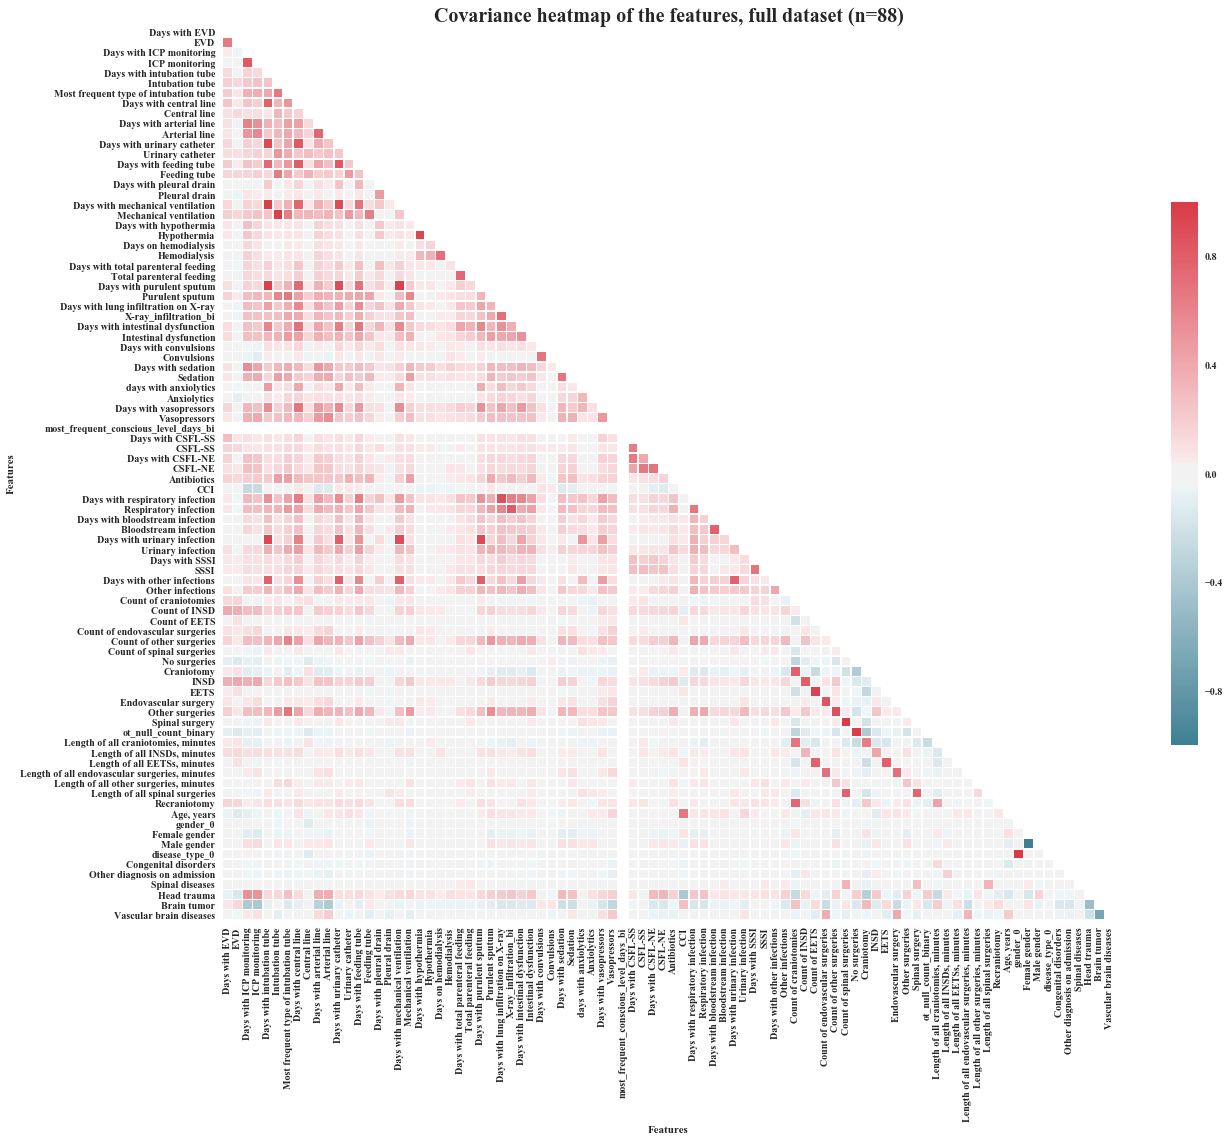

In [14]:
# Check multicollinearity with heatmap

# features_xgb_sf = features_xgb_sf.rename(index=map_col_names)
# X_notcorr.columns.map(map_col_names).values

X_heatmap = X.rename(columns=map_col_names)

print_covariance_heatmap(X_heatmap)
plt.xlabel('Features')
plt.ylabel ('Features')
plt.title('Covariance heatmap of the features, full dataset (n=88)', size=20)

plt.savefig('./final_plots/covariance_X.pdf', dpi=1000)

In [15]:
# Reduce multicollinearity
# Remove columns with vif more than 5

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif = vif.loc[vif['VIF Factor'] <= 2.5]

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [16]:
vif_st = pd.DataFrame()
vif_st["VIF Factor"] = [variance_inflation_factor(X_subset_st.values, i) for i in range(X_subset_st.shape[1])]
vif_st["features"] = X_subset_st.columns

vif_st = vif_st.loc[vif_st['VIF Factor'] <= 2.5]

In [17]:
# Create non-corellated datasets
# Full dataset
X_notcorr = X.loc[:, X.columns.isin(vif.features)]
preproc.fit(X_notcorr)
X_notcorr_scaled = preproc.transform(X_notcorr)

# Subset form statistics
X_notcorr_st = X.loc[:, X.columns.isin(vif_st.features)]
preproc.fit(X_notcorr_st)
X_notcorr_st_scaled = preproc.transform(X_notcorr_st)


In [18]:
def results_summary_to_dataframe(results):
    '''This takes the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [19]:
# Plot ORs forest-plot

# Logistic Regression by statsmodels with l1 method

# Use non-corellated normalized dataset
clf_logit = sm.Logit(df.infection_CNS, X_notcorr_scaled)
 
result = clf_logit.fit_regularized(maxiter=500,  method='l1')

logreg = results_summary_to_dataframe(result)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6809848284984452
            Iterations: 31
            Function evaluations: 32
            Gradient evaluations: 31


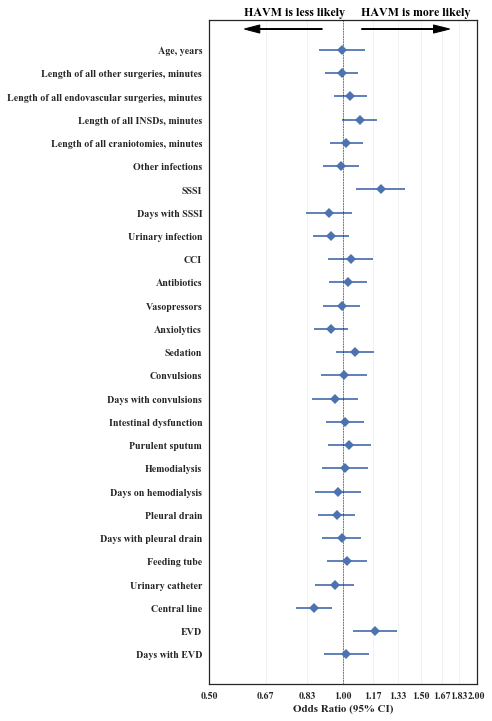

In [20]:

# Make table with odds ratios and confidence intervals for each feature
OR = np.exp(result.params)
CI = np.exp(result.conf_int())

logreg['OR'] = OR
logreg['CI_low'] = CI[0]
logreg['CI_upper'] = CI[1]
logreg.index = X_notcorr.columns.map(map_col_names).values
logreg.to_csv('./logreg_results.csv')

xerr_ = pd.DataFrame([OR.values - CI[0], CI[1] - OR.values]).T
y_values = X_notcorr.columns.map(map_col_names).values
y_axis = np.arange(1, 28)

fig = plt.figure(figsize=(7, 10))

plt.errorbar(OR.values, y_axis, xerr=xerr_.values.T, linestyle="None", fmt='D')

plt.yticks(y_axis, y_values)
plt.xlim(0.5, 2)
plt.xscale('log')

fig.axes[0].set_xticks(np.round(np.linspace(0.5,2,num=10),2), minor=False)
plt.setp(fig.axes[0].get_xminorticklabels(), visible=False)
plt.grid(b=True, which='major', axis='x',alpha=0.25)

plt.axvline(x=1, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('Odds Ratio (95% CI)')
plt.text(0.6, 28.5,'HAVM is less likely', color='black', size=12)
plt.arrow(0.9, 27.9, -0.25, 0, shape='full', lw=1, fc='k', ec='k', head_width=0.35, head_length=0.05 )

plt.text(1.1, 28.5,'HAVM is more likely', color='black', size=12)
plt.arrow(1.1, 27.9, 0.5, 0, shape='full', lw=1, fc='k', ec='k', head_width=0.35, head_length=0.14 )


fig.axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.tight_layout()
plt.savefig('./final_plots/forest_plot_LR_all.pdf', dpi=600)

In [21]:
features_logreg = ['infection_wound_bi', 'EVD_bi', 'central_line_bi']

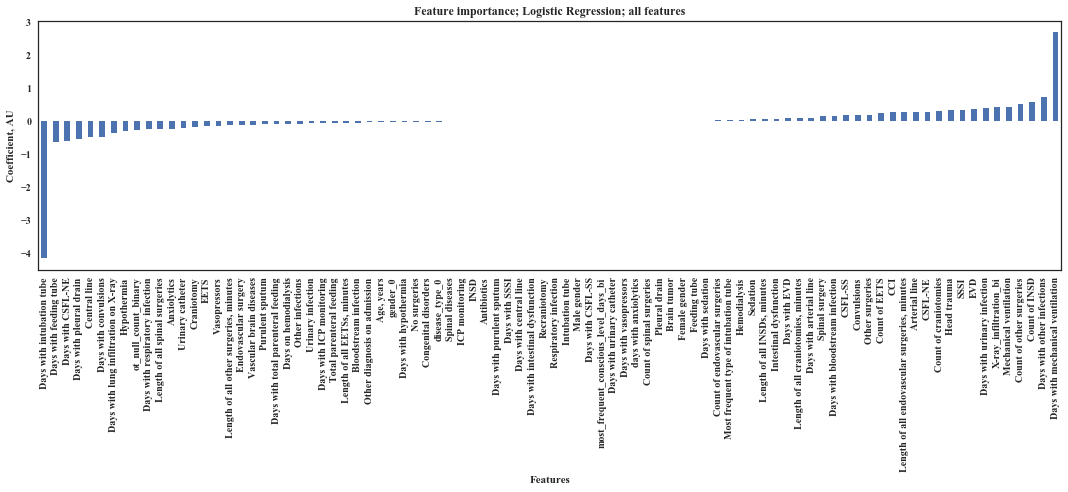

In [22]:
# Just to show that features are highly correlated and feature importance doesn't make sense

clf_LR.fit(X_scaled, y)
fw = pd.Series(clf_LR.coef_.reshape(-1), index=X.columns.map(map_col_names))

fw.sort_values().plot(kind='bar', figsize=(15,7))
plt.xlabel('Features')
plt.ylabel ('Coefficient, AU')
plt.title('Feature importance; Logistic Regression; all features')

plt.tight_layout()

plt.savefig('./final_plots/feature_importance_LR_all.pdf', dpi=600)

# Performance of LogReg

In [23]:
scores = { 'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall',
           'roc_auc': 'roc_auc',
           'neg_log_loss': 'neg_log_loss'
          }


result = {}
for name_clf, clf in [("Logistic Regression;\n", clf_LR)]:
    for name_df, x in [('full dataset (n=88)', X_scaled), ('not correlated features (n=27)', X_notcorr_scaled),
                 ('not correlated features\nfrom univariate analysis (n=6)', X_notcorr_st_scaled)]:
        
            res = cross_validate(clf, x, y, scoring=scores, cv=cv)
            key_ = "{} {}".format(name_clf,name_df)
            
            result[key_] = pd.DataFrame.from_dict(res).mean()
            result[key_ + ' std'] = pd.DataFrame.from_dict(res).std()
            
result = pd.DataFrame.from_dict(result)
result = result.loc[['test_precision','test_recall','test_f1',
                     'test_roc_auc', 'test_neg_log_loss'],:]

result.index = ['Precision', 'Recall', 'F1', 'ROC-AUC', 'Neg Log-Loss']
stds = result.loc[:,result.columns.str.contains('std')]
result = result.loc[:,~result.columns.str.contains('std')]
stds.columns = [x[:-3] for x in stds.columns]

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda

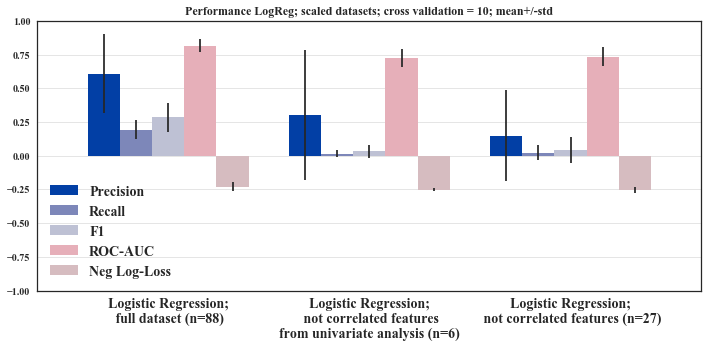

In [24]:
#sns.set_palette(sns.color_palette("Set3", n_colors=8, desat=.5))

# colors = ['#023FA5', '#7D87B9', '#BEC1D4', '#D6BCC0',
#           '#4A6FE3', '#8F95E1', '#B5BBE3', '#E6AFB9',
#           '#11C638', '#8DD593', '#C6DEC7', '#EAD3C6',
#           '#0FCFC0', '#9CDED6', '#D5EAE7', '#F6C4E1',
#           '#BB7784', '#E07B91', '#F0B98D', '#F79CD4']

colors = ['#023FA5', '#7D87B9', '#BEC1D4', '#E6AFB9', '#D6BCC0']
ax = pd.DataFrame(result).T.plot(kind='bar', yerr=stds.loc[result.index, :].values,
                                 figsize=(10,5), width=0.8, legend=False, color = colors)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc="lower left", prop={'size': 14})
labels = ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=14)
plt.grid(b=True, which='major', axis='y',alpha=0.5)
plt.ylim(-1, 1)
plt.title('Performance LogReg; scaled datasets; cross validation = 10; mean+/-std')
plt.tight_layout()
plt.savefig('./final_plots/Performance_LR.pdf', dpi=600)

Mean AUC:		 0.814933 +/- 0.044638
Mean PPV (presision):	 0.608791 +/- 0.279586
Mean NPV:		 0.934000 +/- 0.006580
Mean recall (sensitivity):	 0.192157 +/- 0.067273
Confusion matrix, without normalization
[[  34  144]
 [  32 2038]]


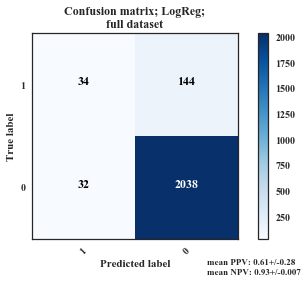

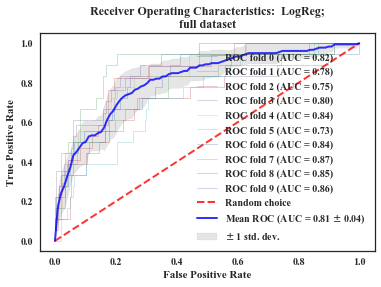

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Mean AUC:		 0.734992 +/- 0.064827
Mean PPV (presision):	 nan +/- 0nan
Mean NPV:		 0.922133 +/- 0.005077
Mean recall (sensitivity):	 0.023203 +/- 0.053707
Confusion matrix, without normalization
[[   4  174]
 [  10 2060]]


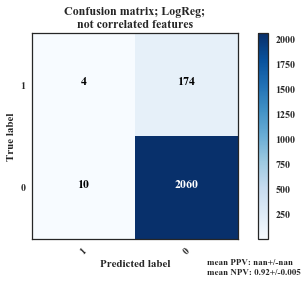

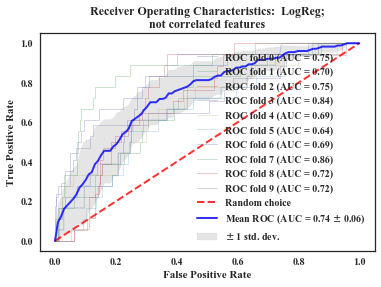

Mean AUC:		 0.725792 +/- 0.061239
Mean PPV (presision):	 nan +/- 0nan
Mean NPV:		 0.921912 +/- 0.002132
Mean recall (sensitivity):	 0.016667 +/- 0.025459
Confusion matrix, without normalization
[[   3  175]
 [   4 2066]]


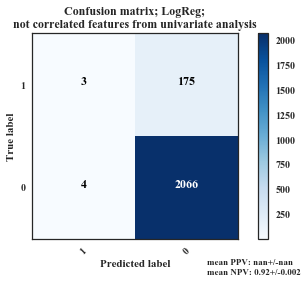

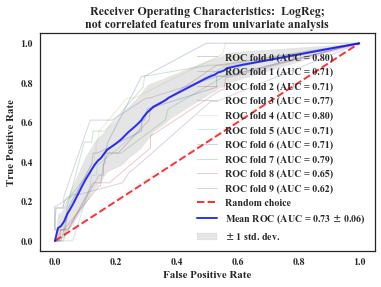

In [25]:
for title, x in [('full dataset', X_scaled), ('not correlated features', X_notcorr_scaled),
                 ('not correlated features from univariate analysis', X_notcorr_st_scaled)]:
    cnf_matrix = calculate_confusion_matrix(clf_LR, pd.DataFrame(x), y, cv=cv)
    cnf_matrix_1 = cnf_matrix[0].T[::-1].T[::-1]
    ppv = 'mean PPV: ' + str(np.around(cnf_matrix[1], 2)) + '+/-' + str(np.around(cnf_matrix[2], 3))
    npv = 'mean NPV: ' + str(np.around(cnf_matrix[3], 2)) + '+/-' + str(np.around(cnf_matrix[4], 3))
    plt.text(1.2, 1.75, ppv, size=9)
    plt.text(1.2, 1.85, npv, size=9)
    plot_confusion_matrix(cnf_matrix_1, [1,0], title ='Confusion matrix; LogReg;\n' +title)
    plt.show()
    
    plot_roc_auc(clf_LR, pd.DataFrame(x), y, cv=cv, title=' LogReg;\n'+title)
    plt.show()

# Principal component analysis

In [27]:
df = pd.get_dummies(df, columns=['gender', 'disease_type'])
pcaX = df.loc[:,~df.columns.isin(['infection_CNS'])]
pcay = df.loc[:,df.columns.isin(['infection_CNS'])]
pcay = pcay.values.reshape(-1)

pcaX_std = StandardScaler().fit_transform(pcaX);  # standardization of data

# Fit the model with pcaX_std and apply the dimensionality reduction on pcaX_std.
pca = PCA(n_components=30) # 30 PCA components
X_pca = pca.fit_transform(pcaX_std)


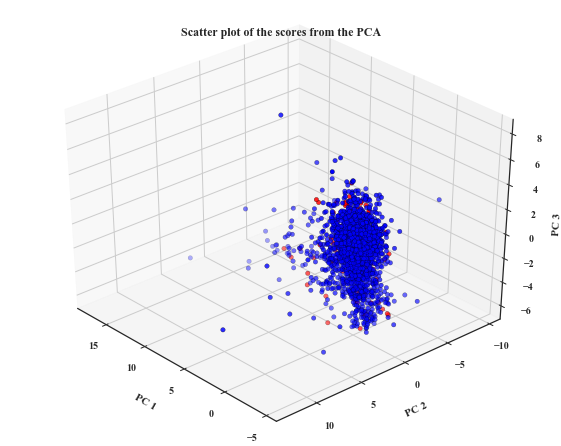

In [28]:
# 3D plot to show 3 random principal components

#first we need to map colors on labels
dfcolor = pd.DataFrame([[1,'red'],[0,'blue']],columns=['infection_CNS','Color'])
mergeddf = pd.merge(df, dfcolor)


centers = [[1, 1], [-1, -1], [1, -1]]
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=35, azim=138)

ax.scatter(X_pca[:, 6], X_pca[:, 17], X_pca[:, 2], color=mergeddf['Color'], cmap=plt.cm.spectral,
           edgecolor='k')

xLabel = ax.set_xlabel('\nPC 1', linespacing=3.2)
yLabel = ax.set_ylabel('\nPC 2', linespacing=3.1)
zLabel = ax.set_zlabel('\nPC 3', linespacing=2.0)
plt.title('Scatter plot of the scores from the PCA')
plt.savefig('./final_plots/pca3d.pdf', dpi=600)
plt.show()

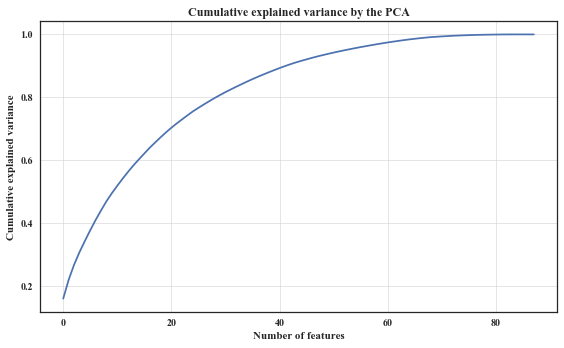

In [29]:
pca = PCA() 

X_pca = pca.fit_transform(pcaX_std)

plt.figure(1, figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.grid(b=True, which='major', axis='both', alpha=0.5)
plt.title('Cumulative explained variance by the PCA')

plt.tight_layout()
plt.savefig('./final_plots/pca_cumsum.pdf', dpi=600)

# XGB & Random Forest

```
Use them to find non-linear relationships
```

## Evaluate performance by metrics

In [30]:
scores = { 'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall',
           'roc_auc': 'roc_auc',
           'neg_log_loss': 'neg_log_loss'
          }


result = {}
for name_clf, clf in [("XGBoost;\n", clf_xgb), ("XGBoost, weighted;\n", clf_xgb_spw),
                      ('Random Forest;\n', clf_rf), ('Random Forest,\nweighted;\n', clf_rf_w)]:
    print("Started for\t", name_clf)
    for name_df, x in [("full dataset (n=88)", X.fillna(0).as_matrix()),
                       ("features from\nunivariate analysis\n(n=11)", X_subset_st.fillna(0).as_matrix())]:
        

            res = cross_validate(clf, x, y, scoring=scores, cv=cv)
            key_ = "{} {}".format(name_clf,name_df)
            
            result[key_] = pd.DataFrame.from_dict(res).mean()
            result[key_ + ' std'] = pd.DataFrame.from_dict(res).std()
            
result = pd.DataFrame.from_dict(result)
result = result.loc[['test_precision','test_recall','test_f1',
                     'test_roc_auc', 'test_neg_log_loss'],:]

result.index = ['Precision', 'Recall', 'F1', 'ROC-AUC', 'Neg Log-Loss']
stds = result.loc[:,result.columns.str.contains('std')]
result = result.loc[:,~result.columns.str.contains('std')]
stds.columns = [x[:-3] for x in stds.columns]

Started for	 XGBoost;



/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Started for	 XGBoost, weighted;

Started for	 Random Forest;

Started for	 Random Forest,
weighted;



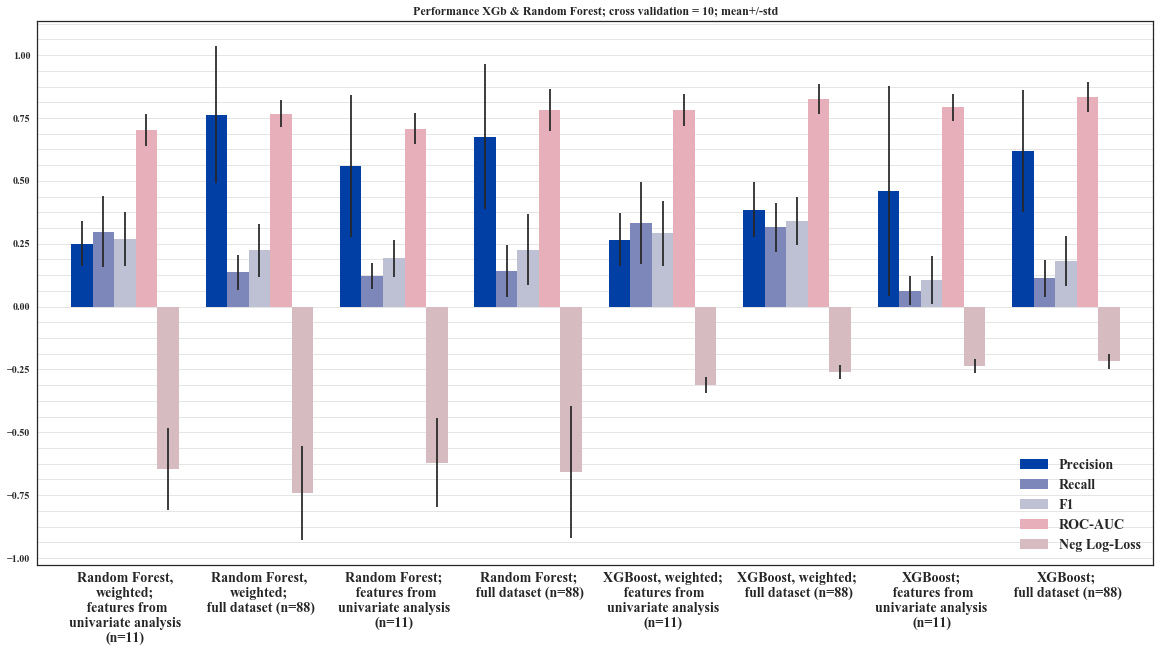

In [31]:
# sns.set_palette(sns.color_palette("hls", 20))
# sns.set_palette(sns.color_palette(colors, 20))

colors = ['#023FA5', '#7D87B9', '#BEC1D4', '#E6AFB9', '#D6BCC0']


ax = pd.DataFrame(result).T.plot(kind='bar', yerr=stds.loc[result.index,:].values,
                                 figsize=(20,10), width=0.8, legend=False, color=colors)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc="lower right", prop={'size': 14})
labels = ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=14)

plt.grid(b=True, which='major', axis='y',alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.5)
plt.title('Performance XGb & Random Forest; cross validation = 10; mean+/-std')

plt.savefig('./final_plots/Performance_xgb+RF.pdf', dpi=600)

## Evaluate the performance XGB&RF by confusion matrices & ROC-AUC

In [32]:
grid = [clfs[1:],
        [X, X_subset_st, X_notcorr]]

grid = list(itertools.product(*grid))


grid_labels = [['Random Forest', 'Random Forest, weighted', 'XGBoost', 'XGBoost, weighted'],
               ['full dataset', 'features from\nunivariate analysis']]

grid_labels = list(itertools.product(*grid_labels))

Mean AUC:		 0.767701 +/- 0.051390
Mean PPV (presision):	 0.763571 +/- 0.259561
Mean NPV:		 0.930439 +/- 0.006151
Mean recall (sensitivity):	 0.135948 +/- 0.066288
Confusion matrix, without normalization
[[  24  154]
 [  11 2059]]


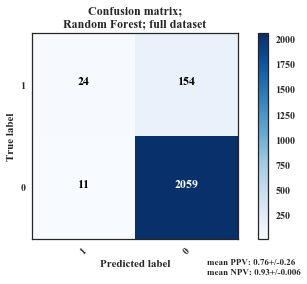

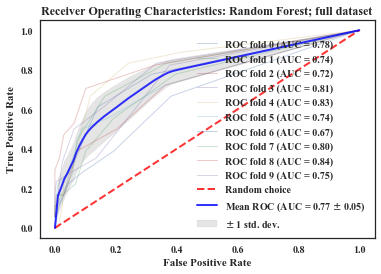

Mean AUC:		 0.701593 +/- 0.059325
Mean PPV (presision):	 0.250796 +/- 0.084131
Mean NPV:		 0.938810 +/- 0.011169
Mean recall (sensitivity):	 0.298039 +/- 0.133210
Confusion matrix, without normalization
[[  53  125]
 [ 156 1914]]


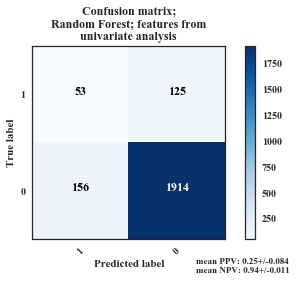

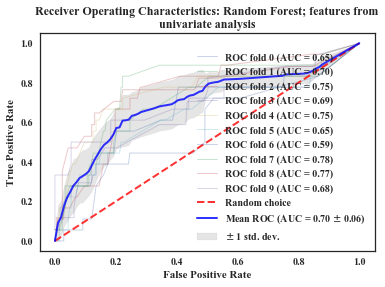

Mean AUC:		 0.688743 +/- 0.053518
Mean PPV (presision):	 0.548333 +/- 0.251490
Mean NPV:		 0.926835 +/- 0.003214
Mean recall (sensitivity):	 0.090196 +/- 0.028384
Confusion matrix, without normalization
[[  16  162]
 [  18 2052]]


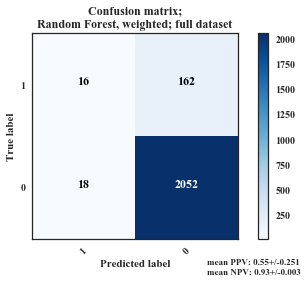

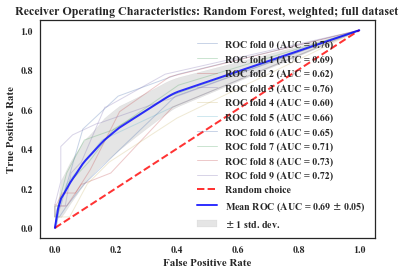

Mean AUC:		 0.833242 +/- 0.056919
Mean PPV (presision):	 0.619762 +/- 0.230336
Mean NPV:		 0.928619 +/- 0.006145
Mean recall (sensitivity):	 0.113399 +/- 0.069938
Confusion matrix, without normalization
[[  20  158]
 [  16 2054]]


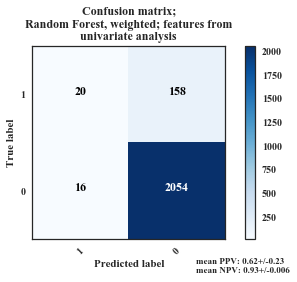

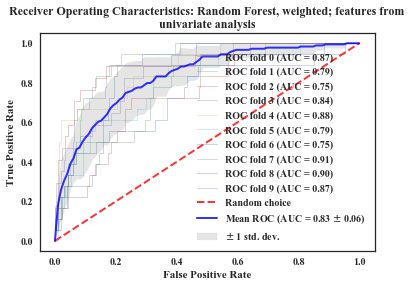

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Mean AUC:		 0.792730 +/- 0.051645
Mean PPV (presision):	 nan +/- 0nan
Mean NPV:		 0.924897 +/- 0.005436
Mean recall (sensitivity):	 0.062745 +/- 0.055050
Confusion matrix, without normalization
[[  11  167]
 [  14 2056]]


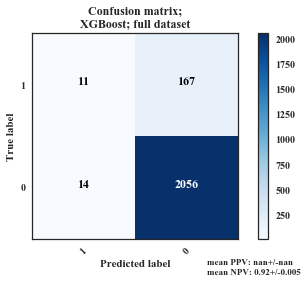

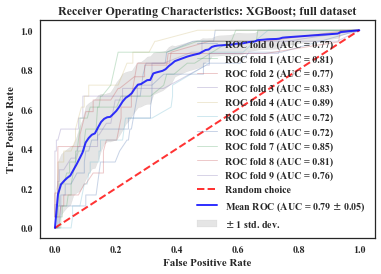

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


Mean AUC:		 0.768940 +/- 0.051755
Mean PPV (presision):	 nan +/- 0nan
Mean NPV:		 0.922366 +/- 0.003339
Mean recall (sensitivity):	 0.022876 +/- 0.028036
Confusion matrix, without normalization
[[   4  174]
 [   3 2067]]


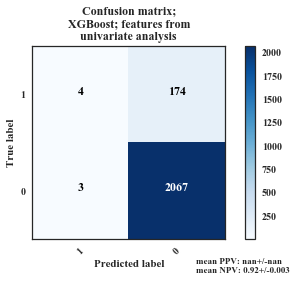

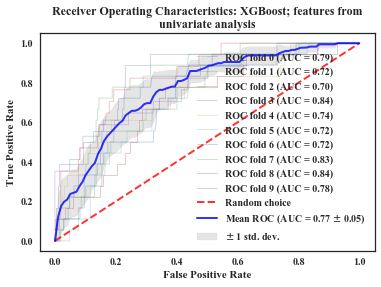

Mean AUC:		 0.825671 +/- 0.057998
Mean PPV (presision):	 0.385166 +/- 0.103709
Mean NPV:		 0.941802 +/- 0.008150
Mean recall (sensitivity):	 0.315033 +/- 0.093183
Confusion matrix, without normalization
[[  56  122]
 [  96 1974]]


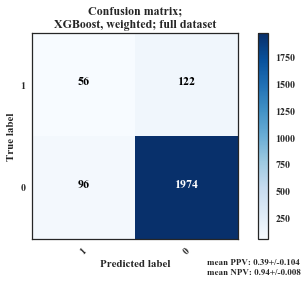

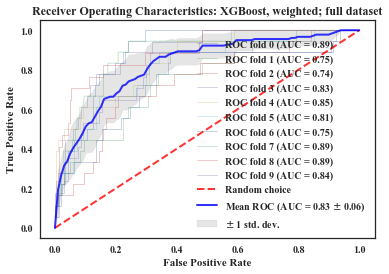

Mean AUC:		 0.781739 +/- 0.059576
Mean PPV (presision):	 0.266486 +/- 0.101014
Mean NPV:		 0.941504 +/- 0.013465
Mean recall (sensitivity):	 0.332353 +/- 0.156372
Confusion matrix, without normalization
[[  59  119]
 [ 160 1910]]


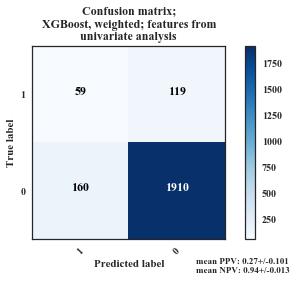

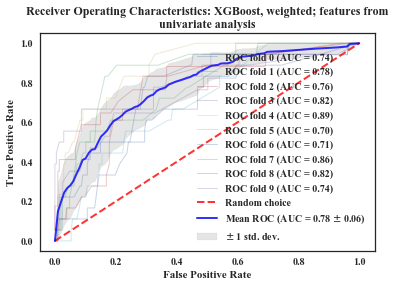

In [33]:
for g, l in zip(grid, grid_labels):
    clf, d = g
    label = "; ".join(list(l))
    d = pd.DataFrame(d)
    cnf_matrix = calculate_confusion_matrix(clf, d, y)
    cnf_matrix_1 = cnf_matrix[0].T[::-1].T[::-1]
    
    # Confusion matrix
    ppv = 'mean PPV: ' + str(np.around(cnf_matrix[1], 2)) + '+/-' + str(np.around(cnf_matrix[2], 3))
    npv = 'mean NPV: ' + str(np.around(cnf_matrix[3], 2)) + '+/-' + str(np.around(cnf_matrix[4], 3))
    plt.text(1.2, 1.75, ppv, size=9)
    plt.text(1.2, 1.85, npv, size=9)
    plot_confusion_matrix(cnf_matrix_1, [1,0], title = 'Confusion matrix;\n' +label)
    plt.show()
    
    # ROC_AUC
    plot_roc_auc(clf, d, y, title=label, savefig=True)
    plt.show()

##  Try SMOTE to improve the performance

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [35]:
print('Initial dataset log-loss:\t',
      log_loss(y_test, clf_xgb_spw.fit(X_train, y_train).predict_proba(X_test)[:,1]))
print('SMOTE dataset log-loss:\t\t',
      log_loss(y_test, clf_xgb_spw.fit(X_train_res, y_train_res).predict_proba(X_test.as_matrix())[:,1]))

Initial dataset log-loss:	 0.251248859687
SMOTE dataset log-loss:		 0.288847020715


```
Conclusion:
1. Don't use SMOT
2. xgb_spw is the best classifier. Use it for feature importance
```

### Feature importance of feature subset from statistical analysis

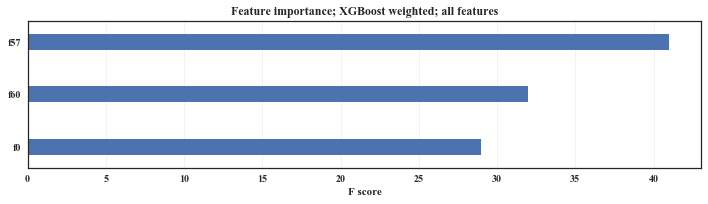

In [36]:
booster = clf_xgb_spw.booster()
fscores = pd.DataFrame.from_dict({'F score': booster.get_fscore()})
fscores = fscores['F score'].sort_values(ascending=False)

top = fscores.head(3)

fig, ax = plt.subplots(1,1, figsize=(10,3))

top.sort_values(ascending=True).plot(kind='barh', width=0.3, ax=ax)
ax.grid(visible=False)
ax.grid(b=True, which='major', axis='x', alpha=0.25, visible=True)
plt.xlabel('F score')
plt.title('Feature importance; XGBoost weighted; all features')

plt.tight_layout()
plt.savefig('./final_plots/feature_importance_XGB_all_top3.pdf', dpi=600)


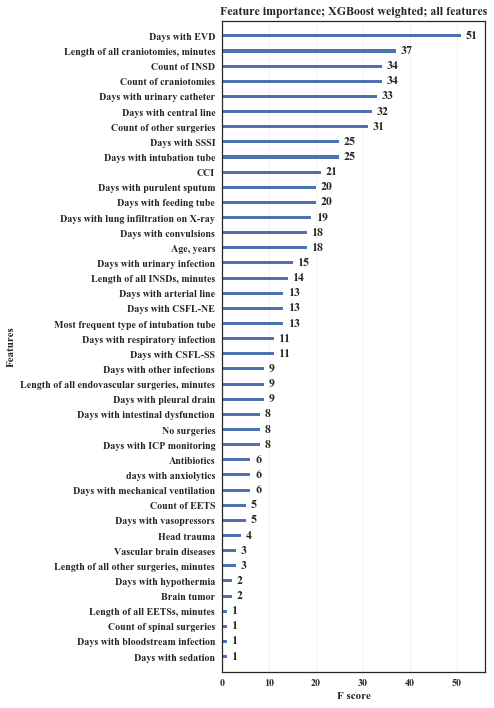

In [37]:
# Built-in xgb feature importance plot

clf_xgb_spw.fit(X.rename(columns=map_col_names), y)

fig, ax = plt.subplots(1,1, figsize=(7,10))

plot_importance(clf_xgb_spw, ax=ax)
ax.grid(visible=False)
ax.grid(b=True, which='major', axis='x', alpha=0.25, visible=True)

plt.title('Feature importance; XGBoost weighted; all features')

plt.tight_layout()
plt.savefig('./final_plots/feature_importance_XGB_all.pdf', dpi=600)

In [38]:
# Save important features from XGBoost (all with non-0 weight)

features_xgb = pd.DataFrame(clf_xgb_spw.feature_importances_, index=X.columns)
features_xgb = features_xgb[features_xgb[0] > 0].index.values
features_xgb.shape

(42,)

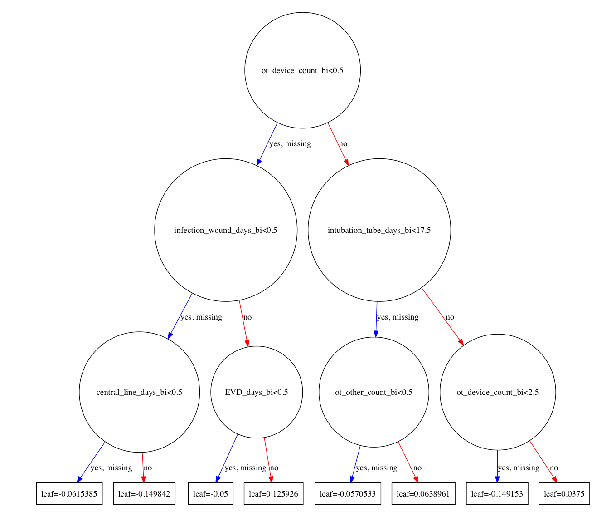

In [39]:
# Plot decision tree

clf_xgb_spw.fit(X, y)

plot_tree(clf_xgb_spw.fit(X, y))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()
fig.savefig('./final_plots/decision_tree_xgb.pdf', dpi=600)


## Artificial score function for feature importance by XGBoost

### Define important features

In [40]:
# Show top-10 features for 10 cross validations

for train, test in cv.split(X, y):
    clf_xgb_spw.fit(X.iloc[train], y[train])
    print(pd.Series(clf_xgb_spw.feature_importances_, index=X.columns).sort_values(ascending=False).head(1))
    print("\n")

EVD_days_bi    0.08402
dtype: float32


EVD_days_bi    0.079239
dtype: float32


EVD_days_bi    0.080342
dtype: float32


EVD_days_bi    0.102609
dtype: float32


EVD_days_bi    0.079032
dtype: float32


EVD_days_bi    0.090016
dtype: float32


EVD_days_bi    0.101587
dtype: float32


ot_craniotomy_len_sum_bi    0.083195
dtype: float32


EVD_days_bi    0.072513
dtype: float32


EVD_days_bi    0.0937
dtype: float32




### Measure feature importances
```
In this section we measure our feature importances using introduced score_function
```

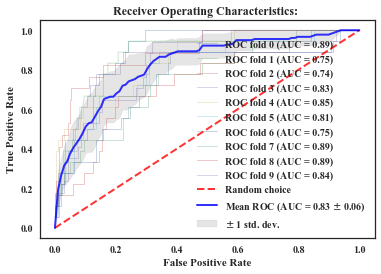

EVD_days_bi                 0.086459
ot_craniotomy_len_sum_bi    0.062411
ot_device_count_bi          0.058373
central_line_days_bi        0.056772
ot_other_count_bi           0.053011
urinary_catheter_days_bi    0.045384
ot_craniotomy_count_bi      0.042946
intubation_tube_days_bi     0.042393
infection_wound_days_bi     0.038824
feeding_tube_days_bi        0.037225
dtype: float64

In [41]:
# Fit xgboost and make cross-validation

res = plot_roc_auc(clf_xgb_spw, X, y, save_weights=True, savefig=False)
res = pd.DataFrame(res[2], columns=X.columns)

# Print mean coefficients for top-10 features
# Bad approach!!

res.mean().sort_values(ascending=False).head(10)

In [42]:
# Define not important features

# TODO
# выбрать действительно неважные, а не те, где осталась вторая фича из скореллированной пары

useless_features = res.loc[1,:].sort_values(ascending=False)[res.loc[1,:].sort_values(ascending=False) == 0]
useful_features = res.loc[1,:].sort_values(ascending=False)[res.loc[1,:].sort_values(ascending=False) != 0]

In [43]:
# Introduce the artificial function to estimate the importance

res_scores_dict = {}

for i in range(10):
    for val in res.loc[i,:].sort_values(ascending=False).head(1).index:
        if val in res_scores_dict.keys():
            res_scores_dict[val] += 1
        else:
            res_scores_dict[val] = 1
            
pd.Series(res_scores_dict).sort_values(ascending=False).head(5)


EVD_days_bi                 9
ot_craniotomy_len_sum_bi    1
dtype: int64

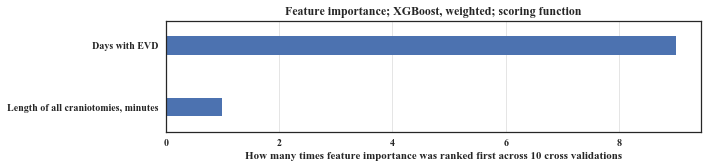

In [44]:
# Save features
features_xgb_sf = pd.Series(res_scores_dict).sort_values(ascending=True)
features_xgb_sf = features_xgb_sf.rename(index=map_col_names)

fig, ax = plt.subplots(1,1, figsize=(10,2.5))

features_xgb_sf.plot.barh(width=0.3, ax=ax)
ax.grid(b=True, which='major', axis='x', alpha=0.5, visible=True)

plt.xlabel ('How many times feature importance was ranked first across 10 cross validations')
plt.title('Feature importance; XGBoost, weighted; scoring function')

plt.tight_layout()
plt.savefig('./final_plots/feature_importance_XGB_scoring_function.pdf', dpi=600)
plt.show()


# Intersect features from all methods

### Test real versus binary features

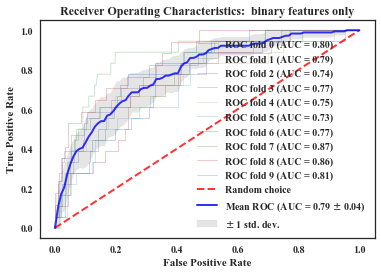

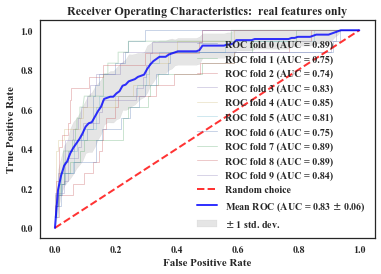

In [45]:
# Simplest way is to compare ROC-curves
binary = plot_roc_auc(clf_xgb_spw, X, y, cv=cv, title=' binary features only',
                      cols_to_except=[x for x in X.columns if 'days' in x])
real = plot_roc_auc(clf_xgb_spw, X, y, cv=cv, title=' real features only',
                      cols_to_except=[x.replace("_days", "") for x in X.columns if 'days' in x])

### Select best features

In [46]:
# We replace features from statistics and logreg by their real analogus
# because the performance of XGB is better with real numbers (or remove binary feature)

features_statistics_new = ['EVD_days_bi', 'central_line_days_bi', 'wound_liquorrhea_days_bi',
             'CSF_leakage_days_bi',  'infection_wound_days_bi', 'ot_other_count_bi',
             'recraniotomy_bi', 'ot_craniotomy_count_bi', 'ot_device_count_bi',
             'ot_endonasal_count_bi']
features_xgb_sf = pd.Series(res_scores_dict).sort_values(ascending=True)
features_logreg_new = ['infection_wound_days_bi', 'EVD_days_bi']

#features_all = features_statistics_new
features_statistics_new.extend(features_logreg_new)
features_statistics_new.extend(features_xgb)
features_statistics_new.extend(features_xgb_sf.index)

super_final_table = pd.DataFrame(features_statistics_new)
super_final_table = super_final_table[0].value_counts().reset_index()
super_final_table.columns = ['col', 'count']
super_final_table.to_csv('./super_final_table.csv')
super_final_table

,col,count
0,EVD_days_bi,4
1,infection_wound_days_bi,3
2,ot_craniotomy_count_bi,2
3,CSF_leakage_days_bi,2
4,central_line_days_bi,2
5,wound_liquorrhea_days_bi,2
6,ot_other_count_bi,2
7,ot_device_count_bi,2
8,ot_endonasal_count_bi,2
9,ot_craniotomy_len_sum_bi,2


# Test features selected by 3 or more methods

In [47]:
# They are:
features_most_important = ['EVD_days_bi',
                           'ot_craniotomy_len_sum_bi',
                           'ot_craniotomy_count_bi',
                           'ot_device_count_bi',
                           'infection_wound_days_bi',
                           'wound_liquorrhea_days_bi',
                           'CSF_leakage_days_bi',
                           'ot_other_count_bi'
                             ]

In [48]:
# Test in permutation by f1 score

clf_xgb_spw.fit(X,y)

res_f1_full = pd.DataFrame.from_dict(cross_validate(clf_xgb_spw, X ,y, cv=cv, scoring=scores)).test_f1
res_f1_subset = pd.DataFrame.from_dict(cross_validate(clf_xgb_spw, X[features_most_important],
                                                      y, cv=cv, scoring=scores)).test_f1

random_cols = [X.iloc[0].T.sample(len(features_most_important)).index.values for _ in range(20)]

res_f1 = {}
res_f1["F1 Full"] = res_f1_full.mean()
res_f1["F1 Best Subset"] = res_f1_subset.mean()

for i, cols in enumerate(random_cols):
    res_f1["F1 Random {}".format(i)] = pd.DataFrame.from_dict(cross_validate(clf_xgb_spw,
                                                                             X[cols], y, cv=cv, 
                                                                             scoring=scores)).test_f1.mean()

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
f1_permut = pd.DataFrame.from_dict({'value': res_f1})
f1_permut.to_csv('./permutation_f1.csv')
f1_permut.iloc[2:len(f1_permut)].describe()

,value
count,20.000000
mean,0.125639
std,0.055378
min,0.010000
25%,0.086821
50%,0.130916
75%,0.153983
max,0.217681


### Test performance

Mean AUC:		 0.753221 +/- 0.063905
Mean PPV (presision):	 0.318524 +/- 0.127379
Mean NPV:		 0.938614 +/- 0.010778
Mean recall (sensitivity):	 0.275817 +/- 0.135353
Confusion matrix, without normalization
[[  49  129]
 [ 103 1967]]


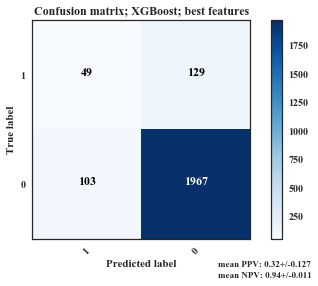

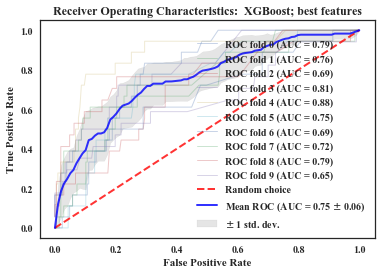

In [50]:
X_subset_best = X.loc[:, features_most_important]

clf_xgb_spw.fit(X_subset_best, y)

cnf_matrix = calculate_confusion_matrix(clf_xgb_spw, X_subset_best, y)
cnf_matrix_1 = cnf_matrix[0].T[::-1].T[::-1]
    
    # Confusion matrix
ppv = 'mean PPV: ' + str(np.around(cnf_matrix[1], 2)) + '+/-' + str(np.around(cnf_matrix[2], 3))
npv = 'mean NPV: ' + str(np.around(cnf_matrix[3], 2)) + '+/-' + str(np.around(cnf_matrix[4], 3))
plt.text(1.2, 1.75, ppv, size=9)
plt.text(1.2, 1.85, npv, size=9)
plot_confusion_matrix(cnf_matrix_1, [1,0], title = 'Confusion matrix; XGBoost; best features')
plt.show()
    
    # ROC_AUC
plot_roc_auc(clf_xgb_spw, X_subset_best, y, title=' XGBoost; best features', savefig=True)
plt.show()


In [51]:
scores = { 'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall',
           'roc_auc': 'roc_auc',
           'neg_log_loss': 'neg_log_loss'
          }


result = {}
for name_clf, clf in [("XGBoost, weighted;\n", clf_xgb_spw),
                      ('Random Forest;\n', clf_rf), ('LogReg;\n', clf_LR)]:
    print("Started for\t", name_clf)
    for name_df, x in [("full dataset (n=88)", X.fillna(0).as_matrix()),
                       ("best features across\nall methods (n=8)", X_subset_best.fillna(0).as_matrix())]:
        

            res = cross_validate(clf, x, y, scoring=scores, cv=cv)
            key_ = "{} {}".format(name_clf,name_df)
            
            result[key_] = pd.DataFrame.from_dict(res).mean()
            result[key_ + ' std'] = pd.DataFrame.from_dict(res).std()
            
result = pd.DataFrame.from_dict(result)
result = result.loc[['test_precision','test_recall','test_f1',
                     'test_roc_auc', 'test_neg_log_loss'],:]

result.index = ['Precision', 'Recall', 'F1', 'ROC-AUC', 'Neg Log-Loss']
stds = result.loc[:,result.columns.str.contains('std')]
result = result.loc[:,~result.columns.str.contains('std')]
stds.columns = [x[:-3] for x in stds.columns]

Started for	 XGBoost, weighted;

Started for	 Random Forest;

Started for	 LogReg;



/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ksun/anaconda

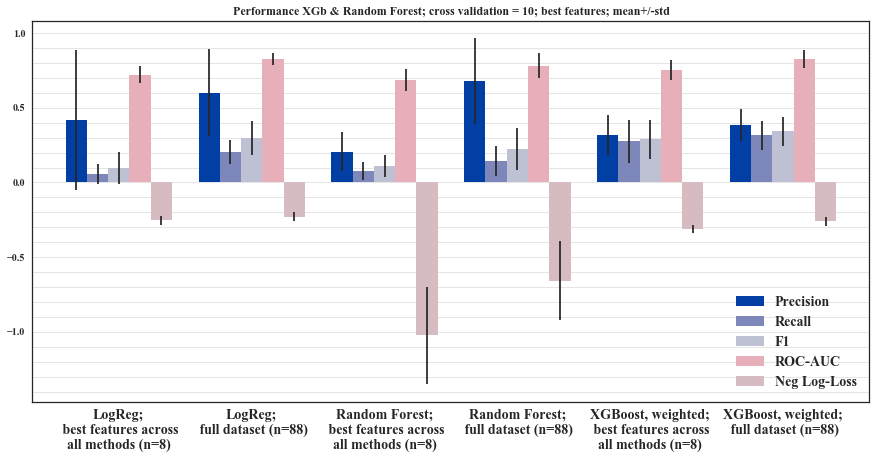

In [ ]:
    # Metrics
colors = ['#023FA5', '#7D87B9', '#BEC1D4', '#E6AFB9', '#D6BCC0']

ax = pd.DataFrame(result).T.plot(kind='bar', yerr=stds.loc[result.index,:].values,
                                 figsize=(15,7), width=0.8, legend=False, color=colors)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc="lower right", prop={'size': 14})
labels = ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=14)

plt.grid(b=True, which='major', axis='y',alpha=0.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', axis='y',alpha=0.5)
plt.title('Performance XGb & Random Forest; cross validation = 10; best features; mean+/-std')

plt.savefig('./final_plots/Performance_xgb+RF+LR_best.pdf', dpi=600)

# Precision-recall curve

In [ ]:
# Thet's why we chose scale_positive_weight=4

fig = plt.figure(figsize=(10, 10))

for w in [2, 4, 6, 8]:
    clf_xgb.scale_pos_weight = w
    y_test = np.array(())
    y_score = np.array(())

    for train, test in cv.split(X, y):
        y_pred = clf_xgb.fit(X.iloc[train], y[train]).predict(X.iloc[test])
        y_pred_proba = clf_xgb.predict_proba(X.iloc[test])[:, 1]
        y_score = np.concatenate([y_score, y_pred_proba])
        y_test = np.concatenate([y_test, y[test]])


    precision, recall, _ = precision_recall_curve(y_test, y_score)

    average_precision = average_precision_score(y_test, y_score)
    accuracy_score = y
    plt.step(recall, precision,
             where='post',
             label="xgb positive weight: {}\nmean precision: {}".format(w,np.around(average_precision, 4)))

    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

plt.legend(loc=0)
plt.axhline(y=0.0945, color='r', linestyle='--', linewidth=0.5)
plt.grid(b=True, which='major', axis='both',alpha=0.5)

plt.title('Precision-recall curve for XGBoost classifier with different pos_weight values, all features')


plt.savefig('./final_plots/Precision_Recall.pdf', dpi=600)

__________